In [36]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [37]:
data = pd.read_csv("train_dat/training_set.csv")
print(list(data.columns))
#data = data.rename(columns = {'type': 'label'})
data = data[data.type > 1]
data.loc[data['type'] ==3, 'label'] = 0
data.loc[data['type'] ==2, 'label'] = 1


print(data.shape)
data.head()

['date', 'type', 'tweet']
(716, 4)


,date,type,tweet,label
0,2016-01-21 06:05:44,3.0,"China Crash to Trigger ‘Financial Ice Age,’ Gl...",0.0
1,2016-01-25 01:04:20,3.0,Australia National Australia Bank's Business C...,0.0
5,2016-01-28 14:00:41,3.0,"""where's mom"" ""died alrdy"" erm bitch she ur wi...",0.0
6,2016-01-29 07:27:36,3.0,Manufacturing production growth in Austria acc...,0.0
8,2016-01-29 16:39:59,3.0,".@martha_j_bailey, @dynarski look at associati...",0.0


In [38]:
from sklearn.model_selection import train_test_split

X = data.tweet.values
y = data.label.values

X_train, X_val, y_train, y_val =\
    train_test_split(X, y, test_size=0.1, random_state=2020)

In [39]:
import nltk
# Uncomment to download "stopwords"
nltk.download("stopwords")
from nltk.corpus import stopwords

def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wcrossb/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [40]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocess text
X_train_preprocessed = np.array([text_preprocessing(text) for text in X_train])
X_val_preprocessed = np.array([text_preprocessing(text) for text in X_val])

# Calculate TF-IDF
tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=True,
                         smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
X_val_tfidf = tf_idf.transform(X_val_preprocessed)



CPU times: user 797 ms, sys: 139 ms, total: 936 ms
Wall time: 936 ms


In [41]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def get_auc_CV(model):
    """
    Return the average AUC score from cross-validation.
    """
    # Set KFold to shuffle data before the split
    kf = StratifiedKFold(5, shuffle=True, random_state=1)

    # Get AUC scores
    auc = cross_val_score(
        model, X_train_tfidf, y_train, scoring="roc_auc", cv=kf)

    return auc.mean()

Best alpha:  8.5


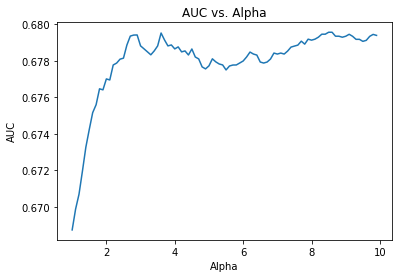

In [42]:
from sklearn.naive_bayes import MultinomialNB
res = pd.Series([get_auc_CV(MultinomialNB(alpha=i)) for i in np.arange(1, 10, 0.1)],index=np.arange(1, 10, 0.1))

best_alpha = np.round(res.idxmax(), 2)
print('Best alpha: ', best_alpha)

plt.plot(res)
plt.title('AUC vs. Alpha')
plt.xlabel('Alpha')
plt.ylabel('AUC')
plt.show()

In [43]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

[0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.
 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0.]
AUC: 0.6865
Accuracy: 72.22%


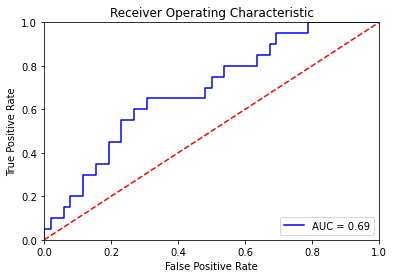

In [45]:
# Compute predicted probabilities
nb_model = MultinomialNB(alpha=8)
nb_model.fit(X_train_tfidf, y_train)
probs = nb_model.predict_proba(X_val_tfidf)

# Evaluate the classifier
print(y_val)
evaluate_roc(probs, y_val)